# Bicing Usage Forecasting - Data Analysis


In [80]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import pathlib
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels as sm
import calendar
from dateutil.relativedelta import *
from datetime import datetime, timedelta

%matplotlib inline 

## Source Data
The data are collect in .csv files. Two categories of .csv file are provided:
* Bicig Station Informations: containing information strictly related to the stations.
* Bicing Station Usage: containing the information of status of all the bicing stations.

In [2]:
dataDirectory = pathlib.Path('data/Bicing/NewBicing_Stations_Info')

pd_stations = pd.read_csv('data/Bicing/NewBicing_Stations_Info/2020_11_Novembre_BicingNou_INFORMACIO.csv')

#pd_stations['last_reported'] = pd.to_datetime(pd_stations['last_reported'], unit='s')
pd_stations['last_updated'] = pd.to_datetime(pd_stations['last_updated'], unit='s')
pd_stations[pd_stations['station_id'] == 1].head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,nearby_distance,cross_street,last_updated,ttl
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16,"GRAN VIA CORTS CATALANES, 760",8013,46,1000,NaN,2020-10-31 23:00:17,4
502,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16,"GRAN VIA CORTS CATALANES, 760",8013,46,1000,NaN,2020-10-31 23:05:43,30
1004,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16,"GRAN VIA CORTS CATALANES, 760",8013,46,1000,NaN,2020-10-31 23:10:33,21
1506,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16,"GRAN VIA CORTS CATALANES, 760",8013,46,1000,NaN,2020-10-31 23:15:16,3
2008,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16,"GRAN VIA CORTS CATALANES, 760",8013,46,1000,NaN,2020-10-31 23:20:43,30


## Data Analysis and Processing

### Identify fixed properties

Most of the fields in the source data hold properties of the bike stations that are mostly fixed in the long period.
An analysis of the variability of the data is carried below to then refactoring and remove repetitions.



In [3]:
# Identify unique attributes in the dataframe based on bike station
df_counter = pd.DataFrame(columns = pd_stations.columns)
for idn in pd_stations.station_id.unique():
    record = [idn]
    station_data = pd_stations[pd_stations['station_id'] == idn]
    for attribute in df_counter.columns[1:]:
        n_values = len(station_data[attribute].unique())
        record.append(n_values)
    df_counter = df_counter.append(pd.Series(record, index = pd_stations.columns), ignore_index=True)
    
df_counter = df_counter.set_index('station_id')
univoque_attributes = []
for attribute in df_counter.columns:
    n_values = df_counter[attribute].max()
    if n_values > 1:
        print('Attribute "{}" is not univoque, with {} different values.' .format(attribute,n_values))
    else:
        univoque_attributes.append(attribute)
        print('Attribute "{}" is univoque.' .format(attribute))

Attribute "name" is univoque.
Attribute "physical_configuration" is univoque.
Attribute "lat" is not univoque, with 3 different values.
Attribute "lon" is not univoque, with 3 different values.
Attribute "altitude" is univoque.
Attribute "address" is univoque.
Attribute "post_code" is univoque.
Attribute "capacity" is not univoque, with 4 different values.
Attribute "nearby_distance" is univoque.
Attribute "cross_street" is univoque.
Attribute "last_updated" is not univoque, with 7274 different values.
Attribute "ttl" is not univoque, with 31 different values.


### Refactoring univoque data

In [4]:
# Refactoring data
# Collect data in a dictionary of dictionaries each collecting the information of one bike station

stations_info = {}
for idn in pd_stations.station_id.unique():
    station_data = pd_stations[pd_stations['station_id'] == idn].iloc[0]
    stations_info[idn] = {"id": idn, "name":station_data['name'], "physical_configuration":station_data['physical_configuration'],
                     "latitude":station_data['lat'], "longitude":station_data['lon'], "streetName":station_data['address'],
                     "post_code":station_data['post_code'], "altitude":station_data['altitude'], "capacity":station_data['capacity'],
                    "nearby_distance":station_data['nearby_distance'], "cross_street":station_data['cross_street']}

del pd_stations
stations_info[1]

{'id': 1,
 'name': 'GRAN VIA CORTS CATALANES, 760',
 'physical_configuration': 'ELECTRICBIKESTATION',
 'latitude': 41.3979779,
 'longitude': 2.1801068999999997,
 'streetName': 'GRAN VIA CORTS CATALANES, 760',
 'post_code': 8013,
 'altitude': 16,
 'capacity': 46,
 'nearby_distance': 1000,
 'cross_street': nan}

In [5]:
dataDirectory = pathlib.Path('data/Bicing/NewBicing_Stations_Status')

pd_stations_st = pd.read_csv('data/Bicing/NewBicing_Stations_Status/2020_09_Setembre_BicingNou_ESTACIONS.csv')

pd_stations_st['last_reported'] = pd.to_datetime(pd_stations_st['last_reported'], unit='s')
pd_stations_st['last_updated'] = pd.to_datetime(pd_stations_st['last_updated'], unit='s')
pd_stations_st.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl
0,1,19,19,0,23,1,1,1,2020-08-31 21:57:33,True,IN_SERVICE,2020-08-31 22:00:39,28
1,2,1,1,0,23,1,1,1,2020-08-31 21:57:38,True,IN_SERVICE,2020-08-31 22:00:39,28
2,3,4,4,0,21,1,1,1,2020-08-31 21:59:46,True,IN_SERVICE,2020-08-31 22:00:39,28
3,4,3,3,0,14,1,1,1,2020-08-31 21:57:54,True,IN_SERVICE,2020-08-31 22:00:39,28
4,5,3,3,0,35,1,1,1,2020-08-31 21:59:30,True,IN_SERVICE,2020-08-31 22:00:39,28


In [6]:
# Refactoring data
# Collect data in a dictionary of dictionaries each collecting the information of one bike station

stations_status = {}
for idn in pd_stations_st.station_id.unique():
    station_data = pd_stations_st[pd_stations_st['station_id'] == idn].iloc[0]
    data = pd_stations_st[pd_stations_st['station_id'] == idn][pd_stations_st.columns[1:]]
    data = data.set_index('last_reported')
    data.sort_index(inplace=True)
    stations_status[idn] = {"id": idn, "data": data}
    
del pd_stations_st
stations_status[1]['data'].head()

,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,is_charging_station,status,last_updated,ttl
last_reported,,,,,,,,,,,
2020-08-31 21:57:33,19,19,0,23,1,1,1,True,IN_SERVICE,2020-08-31 22:00:39,28
2020-08-31 22:02:00,17,17,0,25,1,1,1,True,IN_SERVICE,2020-08-31 22:05:17,6
2020-08-31 22:06:27,20,20,0,22,1,1,1,True,IN_SERVICE,2020-08-31 22:10:41,30
2020-08-31 22:15:17,21,21,0,21,1,1,1,True,IN_SERVICE,2020-08-31 22:15:39,28
2020-08-31 22:19:43,22,22,0,20,1,1,1,True,IN_SERVICE,2020-08-31 22:20:31,20


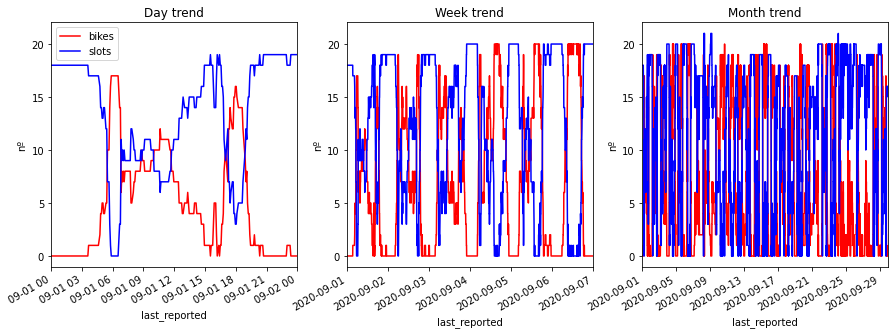

In [7]:
idn = 11
plot_set = stations_status[idn]['data']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_set['num_bikes_available'].plot(title='Day trend', ylabel="nº", color='red',ax=axes[0])
plot_set['num_docks_available'].plot(ylabel="nº", color='blue',ax=axes[0])
axes[0].set_xlim(pd.Timestamp('2020-09-01'), pd.Timestamp('2020-09-02'))
axes[0].legend(['bikes', 'slots']);

plot_set['num_bikes_available'].plot(title='Week trend', ylabel="nº", color='red',ax=axes[1])
plot_set['num_docks_available'].plot(ylabel="nº", color='blue',ax=axes[1])
axes[1].set_xlim(pd.Timestamp('2020-09-01'), pd.Timestamp('2020-09-07'))

plot_set['num_bikes_available'].plot(title='Month trend', ylabel="nº", color='red',ax=axes[2])
plot_set['num_docks_available'].plot(ylabel="nº", color='blue',ax=axes[2])
axes[2].set_xlim(pd.Timestamp('2020-09-01'), pd.Timestamp('2020-09-30'))

fig.autofmt_xdate()
plt.show()

In [8]:
# Minimum Number of bike transfered by the replacement service 
bicing_drop_threshold = 10

stations_usage = {}
for station in stations_status:
    stations_status[station]['data'].sort_index(inplace=True)
    stations_status[station]['data']['bikes_dropped'] = stations_status[station]['data'].num_bikes_available.diff()
    stations_usage[station] = {"id": station, "data": stations_status[station]['data']['bikes_dropped'].apply(lambda x: 0 if abs(x) > bicing_drop_threshold else x)}
    
stations_usage[idn]['data'].loc['2020-09-01'].head()

last_reported
2020-09-01 00:02:00    0.0
2020-09-01 00:06:26    0.0
2020-09-01 00:15:20    0.0
2020-09-01 00:19:47    0.0
2020-09-01 00:24:12    0.0
Name: bikes_dropped, dtype: float64

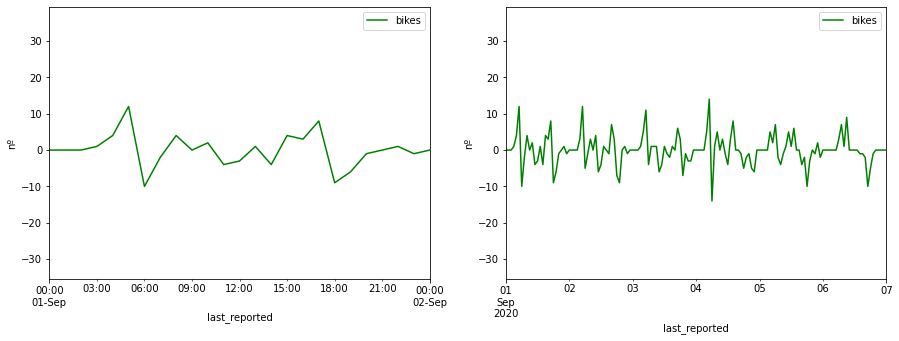

In [27]:
freq = "1h"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
stations_usage[idn]['data'].resample(freq).sum().plot(ylabel="nº", color='green',ax=axes[0])
axes[0].set_xlim(pd.Timestamp('2020-09-01'), pd.Timestamp('2020-09-02'))
axes[0].legend(['bikes', 'slots']);

stations_usage[idn]['data'].resample(freq).sum().plot(ylabel="nº", color='green',ax=axes[1])
axes[1].set_xlim(pd.Timestamp('2020-09-01'), pd.Timestamp('2020-09-07'))
axes[1].legend(['bikes', 'slots']);

Data to hours averages

In [11]:
dataPattern = "*.csv"

for i, dataFile in enumerate(dataDirectory.glob(dataPattern)):
    pd_usage = pd.read_csv(dataFile)
    for station in pd_usage.station_id.unique():
        station_data = pd_usage[pd_usage['station_id'] == station].iloc[0]
        data = pd_usage[pd_usage['station_id'] == station][pd_usage.columns[1:]]
        data['last_reported'] = pd.to_datetime(data['last_reported'], unit='s')
        data = data.set_index('last_reported')
        data['bikes_dropped'] = data.num_bikes_available.diff()
        if station in stations_usage.keys():
            stations_usage[station]['data'] = pd.concat([stations_usage[station]['data'], data['bikes_dropped'].apply(lambda x: 0 if abs(x) > bicing_drop_threshold else x)])
            stations_usage[station]['data'].sort_index(inplace=True)
        else:
            stations_usage[station] = {"id": station, "data": data['bikes_dropped'].apply(lambda x: 0 if abs(x) > bicing_drop_threshold else x)}

stations_usage[idn]['data'].head()

last_reported
2019-03-28 17:56:36    NaN
2019-03-28 18:14:09   -1.0
2019-03-28 18:18:29    0.0
2019-03-28 18:22:50    1.0
2019-03-28 18:27:13   -2.0
Name: bikes_dropped, dtype: float64

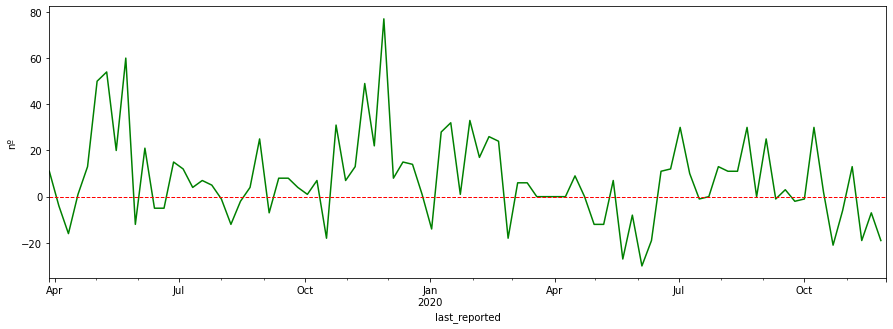

In [34]:
freq = "7d"

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
stations_usage[idn]['data'].resample(freq).sum().plot(ylabel="nº", color='green')
axes.set_xlim(pd.Timestamp('2019-03-28'), pd.Timestamp('2020-11-30'))
axes.axhline(linewidth=1, linestyle='dashed', color='r')
#axes.set_ylim(-10,10)

For station 11 a net drop of bikes is recorded for most of the dataset, widly exceeding the capacity of the station.

# Test and Training Set


The `create_training_series` function, which should take in our list of complete time series data and return a list of truncated, training time series.

* In this example, we want to predict the next week worth of data, and we'll set `prediction_length` to 7 (days).
* To create a training set of data, we'll leave out the last 30 points of *each* of the time series we just generated, so we'll use only the first part as training data. 
* The **test set contains the complete range** of each time series.

In [89]:
def make_time_series(station_df, freq='1h', start_week_day='Monday', weeks = 4):
    '''Creates as many time series as there are complete years. This code
       accounts for the leap year, 2008.
      :param mean_power_df: A dataframe of global power consumption, averaged by day.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2007', '2008'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 16, points to '2017-01-01'. 
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    min_date = min(station_df.index)
    max_date = max(station_df.index)
    
    date = min_date.replace(hour=0, minute=0, second=0, microsecond=0)
    date = date + timedelta(days=1)
    while date+relativedelta(weekday=MO(+1))+timedelta(days = weeks*7) < max_date:
        t_start = date + relativedelta(weekday=MO(+1))
        t_end = date + relativedelta(weekday=MO(+1))+timedelta(days = weeks*7)
        data = station_df.resample(freq).sum()[t_start:t_end]
        time_series.append(data)
        date = t_start + timedelta(days=1)
        
    # return list of time series
    return time_series

In [94]:
# make time series
time_series = make_time_series(stations_usage[idn]['data'])

In [95]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []

    for ts in complete_time_series:
        # truncate trailing `prediction_length` pts
        time_series_training.append(ts[:-prediction_length])

    return time_series_training

In [96]:
# test your code!

# set prediction length
prediction_length = 7 # 7 days, a week

time_series_training = create_training_series(time_series, prediction_length*24)

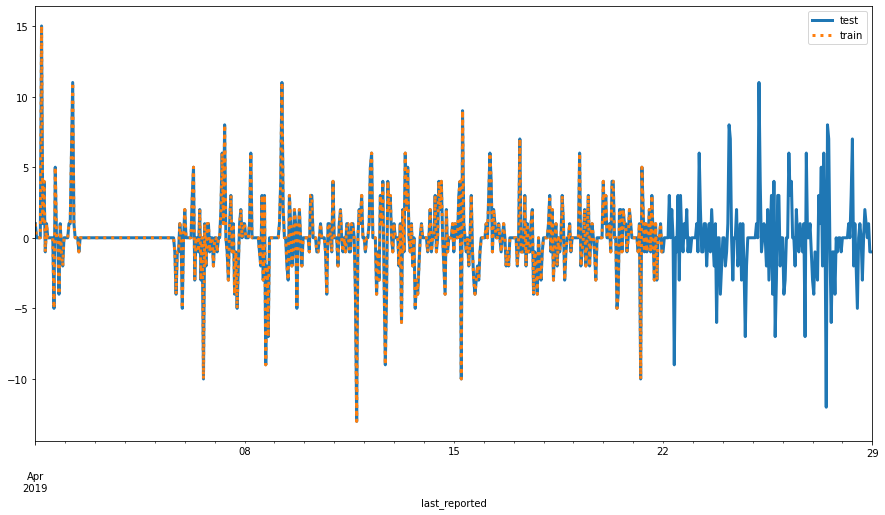

In [97]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON 

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
In the above example, each time series has one, associated categorical feature and one time series feature.

### Formatting Bicing Usage Data

For our data:
* The starting date, "start," will be the index of the first row in a time series, Jan. 1st of that year.
* The "target" will be all of the energy consumption values that our time series holds.
* We will not use the optional "cat" field.

Complete the following utility function, which should convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume.

In [99]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [100]:
# test out the code
ts = time_series[0]

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2019-04-01 00:00:00', 'target': [1.0, 0.0, 0.0, 0.0, 0.0, 15.0, 1.0, 4.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.0, 5.0, 0.0, 0.0, -4.0, 1.0, -1.0, -2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 6.0, 11.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -4.0, -1.0, -1.0, 1.0, 0.0, -5.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 5.0, -3.0, 0.0, 0.0, -1.0, 2.0, -3.0, 0.0, -10.0, 1.0, -2.0, 1.0, 1.0, -1.0, 0.0, 0.0, -2.0, 0.0, 0.0, -1.0, 0.0, 0.0, 2.0, 6.0, 1.0, 8.0, 0.0, -1.0, -3.0, 1.0, 3.0, -1.0, 1.0, -4.0, -1.0, -5.0, -2.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -2.0, 3.0, -3.0, 3.0,

## Save data to export on S3

In [101]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [103]:
# save this data to a local directory
data_dir = 'json_bicing_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [104]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_bicing_data/train.json saved.
json_bicing_data/test.json saved.
